# Model tuning

## Data preparation

In [295]:
# Ignore all warnings
from warnings import simplefilter
simplefilter(action='ignore')

# Import dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import imblearn.over_sampling as OS

# Import the models from SKLearn (Model 1 through Model 6)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Import the modules to evaluate the models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve
from sklearn.metrics import roc_curve, auc

# GridSearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [92]:
# Local module
from ml_classification import model_performance

### Functions

In [190]:
# Define plot parameters
main_color = '#969696'
highlight_color = '#04bfb3'
default_figsize = (10,6)

In [93]:
def upsample_smote(X_train, y_train, verbose=False):

	n_pos = np.sum(y_train == 1)
	n_neg = np.sum(y_train == 0)

	# Create Nx as many positive samples
	N = 50
	ratio = {1: n_pos*N, 0: n_neg}

	# Randomly oversample
	ROS = OS.SMOTE(
		sampling_strategy = ratio,
		random_state = 42
	)

	X_train_rs, y_train_rs = ROS.fit_resample(X_train, y_train)

	if verbose:
		print(f"Original Pos Class Count: {np.sum(y_train)}")
		print(f"Oversample Pos Class Count: {np.sum(y_train_rs)}")

	return X_train_rs, y_train_rs

In [94]:
def get_predictions(model, X):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]
    # return classification and probabilities
    return y_pred, y_proba

In [294]:
# REPEATED FROM MODEL PERFORMANCE NOTEBOOK
def model_performance_metrics(y_test, y_proba, y_pred, model_name='Unnamed'):
    
    # Calculate accuraccy, precision, recall and F1-score
    accuracy = accuracy_score(y_test, y_pred)*100
    precision = precision_score(y_test, y_pred)*100
    recall = recall_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred)*100

    # Get P-R curve parameters (numpy arrays)
    p_curve, r_curve, t_curve = precision_recall_curve(y_test, y_proba)
    f1_scores = [f1_score(y_test, (y_proba >= t)) for t in t_curve]

    # ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)*100

    # ROC curve parameters
    roc_param = {
        'fpr': fpr,
        'tpr': tpr,
        'thr': thresholds
    }

    # Precision-Recall curve parameters
    pr_curve = {
        'p_curve': p_curve,
        'r_curve': r_curve,
        't_curve': t_curve,
        'f1_curve': f1_scores
    }

    # Group all metrics
    metrics = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc_score
    }

    return metrics, pr_curve, roc_param

def plot_prcurve(pr_curve, model_name='Unnamed'):
    p_curve, r_curve, t_curve, f1_scores = pr_curve['p_curve'], pr_curve['r_curve'], pr_curve['t_curve'], pr_curve['f1_curve']

    # Plot curve
    fig, ax = plt.subplots(figsize=(10,6))

    sns.despine()
    
    ax.plot(t_curve, p_curve[:-1], label = 'Precision', ls='--', c=main_color)
    ax.plot(t_curve, r_curve[:-1], label = 'Recall', c=main_color)
    ax.plot(t_curve, f1_scores, label='F1 Curve', c=highlight_color)

    ax.set_xlabel('Prediction Threshold')
    ax.set_ylabel('Scores')
    
    ax.legend()
    
    fig.suptitle('Precision-Recall Curve')
    ax.set_title(f'Model: {model_name}')

    plt.show()

### Data import

In [96]:
with open('feat_target.bin','rb') as f:
    features_target = pickle.load(f)

X = features_target['X']
y = features_target['y']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1,stratify=y, test_size=0.2)
X_train, y_train = upsample_smote(X_train, y_train)

## Evaluate models

In [138]:
def search_cv(model_type, search_type, params, scoring, n_iter=100):
    
    # Select model type
    if model_type == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier()
    elif model_type == 'LogisticRegression':
        model = LogisticRegression()
    elif model_type == 'KNeighborsClassifier':
        model = KNeighborsClassifier()
    elif model_type == 'RandomForestClassifier':
        model = RandomForestClassifier()
    elif model_type == 'GradientBoostingClassifier':
        model = GradientBoostingClassifier()
    elif model_type == 'SVC':
        model = SVC()

    # Select search types
    if search_type == 'Random':
        grid = RandomizedSearchCV(model, params, scoring=scoring, n_iter=n_iter)
    elif search_type == 'Grid':
        grid = GridSearchCV(model, params, scoring=scoring)

    # Train models
    grid.fit(X_train, y_train)

    return grid.best_params_

In [111]:
def get_performance(model, X_test, y_test, model_name):
    # Get predictions
    y_pred, y_proba = get_predictions(model, X_test)

    # Get model performance metrics
    metrics_2, pr_curve_2, roc_param_2 = model_performance_metrics(y_test, y_proba, y_pred, model_name=model_name)

    return metrics_2

### Model 0: Classification Tree

#### Random search

In [99]:
# Define search parameters
params = {
    'max_depth': np.arange(start=1, stop=11, step=1),
    'min_samples_leaf': [2, 5, 10, 20, 100]
}

scoring='precision'

best_params = search_cv('DecisionTreeClassifier', 'Random', params, scoring, n_iter=100)
best_params

{'min_samples_leaf': 5, 'max_depth': 5}

#### Grid search

In [100]:
# Define search parameters
params = {
    'max_depth': np.arange(start=1, stop=11, step=1),
    'min_samples_leaf': np.arange(start=1, stop=21, step=1)
}

scoring='precision'

best_params_0 = search_cv('DecisionTreeClassifier', 'Grid', params, scoring)
best_params_0

{'max_depth': 5, 'min_samples_leaf': 4}

#### Model with best parameters

In [112]:
# Initiate and fit model (unpack best parameters)
model_0_tuned = DecisionTreeClassifier(**best_params_0).fit(X_train, y_train)
metrics_0 = get_performance(model_0_tuned, X_test, y_test, 'Tuned Class. Tree')
display(pd.DataFrame([metrics_0]))

,model,accuracy,precision,recall,f1_score,auc_score
0,Tuned Class. Tree,98.72549,65.116279,71.794872,68.292683,88.42694


### Model 1: Linear Regression

#### Random search

In [102]:
# Define search parameters
params = {
    'C': np.linspace(.1, 1, 10),
    'penalty': ['l1', 'l2', 'elsticnet'],
    'solver': ['saga']
}

scoring='precision'

best_params_1 = search_cv('LogisticRegression', 'Random', params, scoring, n_iter=100)
best_params_1

{'solver': 'saga', 'penalty': 'l2', 'C': 0.4}

In [114]:
# Initiate and fit model (unpack best parameters)
model_1_tuned = LogisticRegression(**best_params_1).fit(X_train, y_train)
metrics_1 = get_performance(model_1_tuned, X_test, y_test, 'Tuned Log. Reg.')
display(pd.DataFrame([metrics_1]))

,model,accuracy,precision,recall,f1_score,auc_score
0,Tuned Log. Reg.,97.990196,48.076923,64.102564,54.945055,89.014467


### Model 2: KNN

#### Random search

In [117]:
# Define search parameters
params = {
    'n_neighbors': np.arange(start=1, stop=20, step=1)
}

scoring='f1'

best_params_2 = search_cv('KNeighborsClassifier', 'Random', params, scoring, n_iter=100)
best_params_2

{'n_neighbors': 2}

In [118]:
# Instantiate the model
model_2_tuned = KNeighborsClassifier(**best_params_2).fit(X_train, y_train)
metrics_2 = get_performance(model_2_tuned, X_test, y_test, 'Tuned KNN')
display(pd.DataFrame([metrics_2]))

,model,accuracy,precision,recall,f1_score,auc_score
0,Tuned KNN,98.333333,69.230769,23.076923,34.615385,77.668217


### Model 3: Random Forest

#### Random search

In [123]:
# NOTE: this cell can take around 5-10 min to run
# Define search parameters
params = {
    'random_state': [1],
    'n_jobs': [-1],
    'n_estimators': np.arange(start=100, stop=1100, step=100),
	'max_features': [None, 'sqrt'],
	'bootstrap': [True, False],
	'max_samples': [None, .3, .5, .9],
	'max_depth': np.arange(start=1, stop=11, step=1),
	'min_samples_leaf': [2, 5, 10, 20, 100]
}

scoring='precision'

best_params_3 = search_cv('RandomForestClassifier', 'Random', params, scoring, n_iter=100)
best_params_3

{'random_state': 1,
 'n_jobs': -1,
 'n_estimators': 100,
 'min_samples_leaf': 5,
 'max_samples': None,
 'max_features': None,
 'max_depth': 5,
 'bootstrap': False}

In [124]:
# Instantiate the model
model_3_tuned = RandomForestClassifier(**best_params_3).fit(X_train, y_train)
metrics_3 = get_performance(model_3_tuned, X_test, y_test, 'Tuned Rand. Forest')
display(pd.DataFrame([metrics_3]))

,model,accuracy,precision,recall,f1_score,auc_score
0,Tuned Rand. Forest,98.72549,65.116279,71.794872,68.292683,88.444239


### Model 4: Gradient Boosted Machine


In [130]:
# NOTE: this cell can take around 50-60 min to run
# Define search parameters
params = {
    'random_state': [1],
	'n_estimators': np.arange(start=100, stop=1100, step=100),
	'learning_rate': [.001, .01, .1, .2],
	'max_features': [None, 'sqrt'],
	'subsample': [.8, .9, 1.0],
	'max_depth': np.arange(start=3, stop=12, step=2),
	'min_samples_leaf': [2, 5, 10]
}

scoring='precision'

best_params_4 = search_cv('GradientBoostingClassifier', 'Random', params, scoring, n_iter=100)
best_params_4

{'subsample': 0.9,
 'random_state': 1,
 'n_estimators': 900,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 11,
 'learning_rate': 0.2}

In [131]:
# Instantiate the model
model_4_tuned = GradientBoostingClassifier(**best_params_4).fit(X_train, y_train)
metrics_4 = get_performance(model_4_tuned, X_test, y_test, 'Tuned GBM')
display(pd.DataFrame([metrics_4]))

,model,accuracy,precision,recall,f1_score,auc_score
0,Tuned GBM,99.362745,100.0,66.666667,80.0,95.541973


### Model 5: SVM

In [141]:
# NOTE: this cell can take around 5-10 min to run
params = {
    'probability': [True],
    'C': [.1, 1], # regularisation
    'kernel': ['linear', 'poly'], # 'rbf', 'sigmoid', 'precomputed'],
    'degree': [3],
    #'gamma': ['scale', 'auto'],
}

scoring='precision'

best_params_5 = search_cv('SVC', 'Random', params, scoring, n_iter=100)
best_params_5

{'probability': True, 'kernel': 'linear', 'degree': 3, 'C': 0.1}

In [142]:
# Instantiate and fit the model
model_5_tuned = SVC(**best_params_5).fit(X_train, y_train)
metrics_5 = get_performance(model_5_tuned, X_test, y_test, 'Tuned SVM')
display(pd.DataFrame([metrics_5]))

,model,accuracy,precision,recall,f1_score,auc_score
0,Tuned SVM,99.264706,100.0,61.538462,76.190476,91.035252


## Compare models

In [143]:
compare_models = pd.DataFrame([metrics_0, metrics_1, metrics_2, metrics_3, metrics_4, metrics_5])

display(compare_models.sort_values('f1_score', ascending=False))

,model,accuracy,precision,recall,f1_score,auc_score
4,Tuned GBM,99.362745,100.000000,66.666667,80.000000,95.541973
5,Tuned SVM,99.264706,100.000000,61.538462,76.190476,91.035252
0,Tuned Class. Tree,98.725490,65.116279,71.794872,68.292683,88.426940
3,Tuned Rand. Forest,98.725490,65.116279,71.794872,68.292683,88.444239
1,Tuned Log. Reg.,97.990196,48.076923,64.102564,54.945055,89.014467
2,Tuned KNN,98.333333,69.230769,23.076923,34.615385,77.668217


### Compare models ROC and AUC

In [151]:
y_pred, y_proba = get_predictions(model_0_tuned, X_test)
metrics_0, pr_curve_0, roc_param_0 = model_performance_metrics(y_test, y_proba, y_pred, model_name="Tuned Class. Tree")

In [152]:
y_pred, y_proba = get_predictions(model_4_tuned, X_test)
metrics_4, pr_curve_4, roc_param_4 = model_performance_metrics(y_test, y_proba, y_pred, model_name="Tuned GBM")

In [153]:
y_pred, y_proba = get_predictions(model_5_tuned, X_test)
metrics_5, pr_curve_5, roc_param_5 = model_performance_metrics(y_test, y_proba, y_pred, model_name="Tuned SVM")

In [199]:
main_color_dark = '#767676'
main_color_darker = '#515151'
main_color_darkest = '#181818'

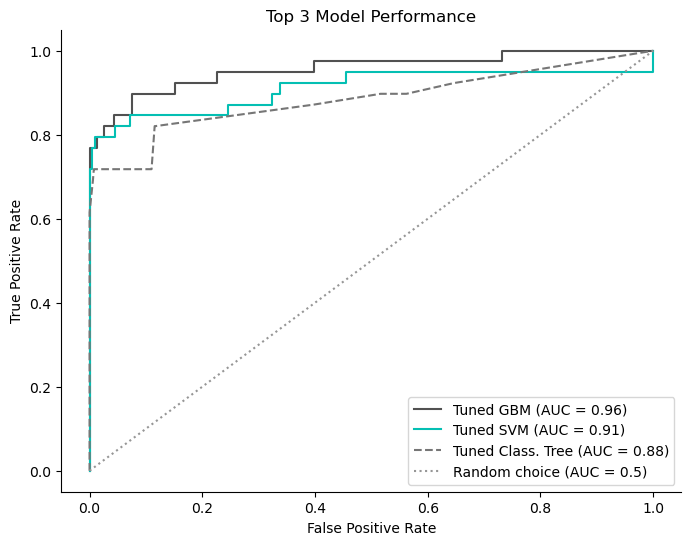

In [207]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))

sns.despine()

ax.plot(roc_param_4['fpr'], roc_param_4['tpr'], label=f"{metrics_4['model']} (AUC = {metrics_4['auc_score']/100:.2f})", c=main_color_darker)
ax.plot(roc_param_5['fpr'], roc_param_5['tpr'], label=f"{metrics_5['model']} (AUC = {metrics_5['auc_score']/100:.2f})", c=highlight_color)
ax.plot(roc_param_0['fpr'], roc_param_0['tpr'], label=f"{metrics_0['model']} (AUC = {metrics_0['auc_score']/100:.2f})", c=main_color_dark, ls='--')
ax.plot([0, 1], [0, 1], ls=':', c=main_color, label='Random choice (AUC = 0.5)')

ax.set_title('Top 3 Model Performance')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.legend()

plt.show()

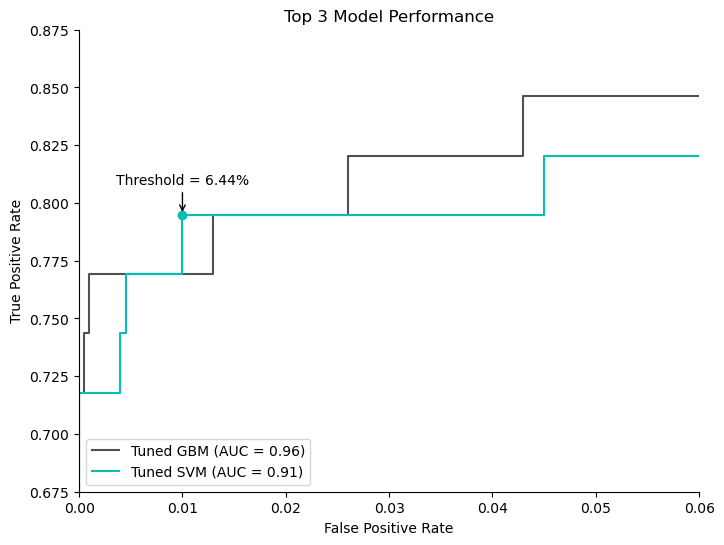

In [247]:
fig, ax = plt.subplots(figsize=(8,6))

sns.despine()

ax.plot(roc_param_4['fpr'], roc_param_4['tpr'], label=f"{metrics_4['model']} (AUC = {metrics_4['auc_score']/100:.2f})", c=main_color_darker)
ax.plot(roc_param_5['fpr'], roc_param_5['tpr'], label=f"{metrics_5['model']} (AUC = {metrics_5['auc_score']/100:.2f})", c=highlight_color)

ax.scatter(roc_param_5['fpr'][8], roc_param_5['tpr'][8], c=highlight_color)
ax.annotate(
    f"Threshold = {100*roc_param_5['thr'][8]:.2f}%",
    [roc_param_5['fpr'][8], roc_param_5['tpr'][8]],
    verticalalignment='bottom',
    horizontalalignment='center',
    arrowprops=dict(arrowstyle= '->'),
    xytext=[roc_param_5['fpr'][8]+.0, roc_param_5['tpr'][8]+.012])

ax.set_title('Top 3 Model Performance')

ax.set_xlim(0, .06)
ax.set_ylim(.675, .875)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.legend(loc='lower left')

plt.show()

## Model selection
Finally, we look at how the classification threshold can be optimised based on the Precision-Recall curves for the Gradient Boost Machine and SVM models. We plot the Precision-Recall curves for both models and select the threshold that maximises the F1-score.

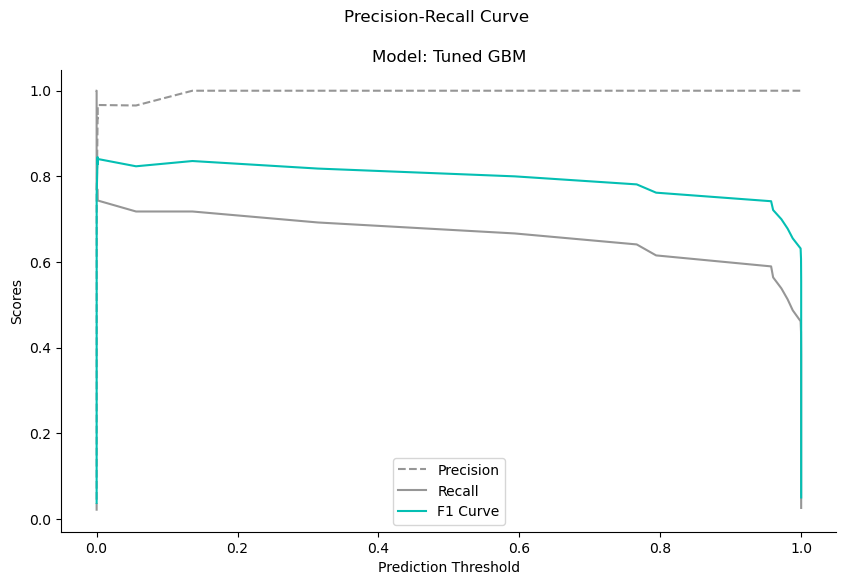

In [256]:
plot_prcurve(pr_curve_4, model_name=metrics_4['model'])

In [288]:
# Index where F1 curve is maximised in Model 4 (GBM)
f1_max_4 = pr_curve_4['f1_curve'].index(max(pr_curve_4['f1_curve']))

tuned_metrics_4 = pd.DataFrame([{
    'model': metrics_4['model'],
    'threshold': pr_curve_4['t_curve'][f1_max_4],
    'precision': pr_curve_4['p_curve'][f1_max_4],
    'recall': pr_curve_4['r_curve'][f1_max_4],
    'f1_score': pr_curve_4['f1_curve'][f1_max_4]
}])

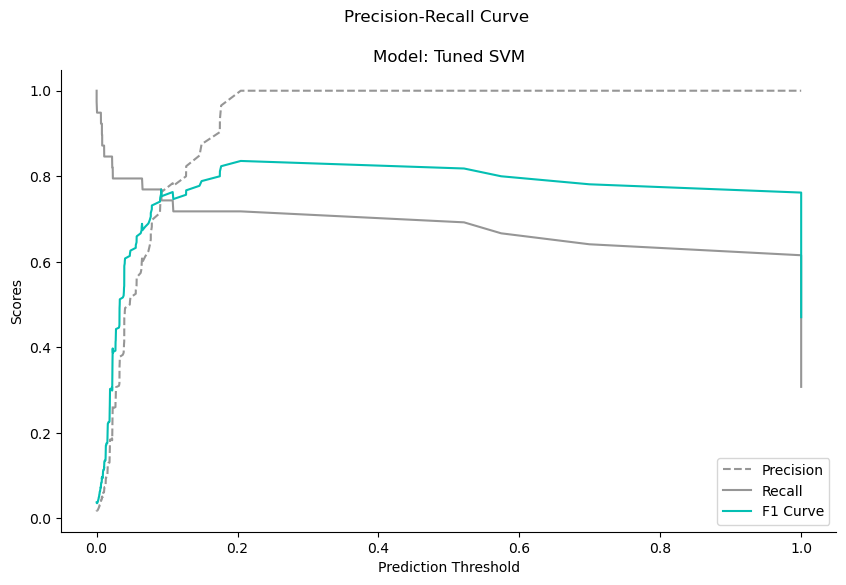

In [257]:
plot_prcurve(pr_curve_5, model_name=metrics_5['model'])

In [290]:
# Index where F1 curve is maximised in Model 5 (SVM)
f1_max_5 = pr_curve_5['f1_curve'].index(max(pr_curve_5['f1_curve']))

tuned_metrics_5 = pd.DataFrame([{
    'model': metrics_5['model'],
    'threshold': pr_curve_5['t_curve'][f1_max_5],
    'precision': pr_curve_5['p_curve'][f1_max_5],
    'recall': pr_curve_5['r_curve'][f1_max_5],
    'f1_score': pr_curve_5['f1_curve'][f1_max_5]
}])

In [293]:
select_model = pd.concat([tuned_metrics_4, tuned_metrics_5])
select_model

,model,threshold,precision,recall,f1_score
0,Tuned GBM,0.001383,0.9375,0.769231,0.845070
0,Tuned SVM,0.204538,1.0000,0.717949,0.835821


## Next steps
We select the SVM model to move forward to the next steps. While the GBM model appear to be the superior one, the time and resources required to tune and train it make it less convenient than the alternative. Moreover, the SVM model offers a great level of performance after this first round of tuning and is very promising.

The next steps include:
1. Final tuning of the model
2. Final validation, testing and performance estimation
3. Model deployment 